In [1]:
# import wget
import os
import glob
import random
import numpy as np
import os,shutil
import matplotlib 
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from os import listdir
from torch.utils.data import Dataset
from skimage.transform import resize
from IPython.display import clear_output
import torchvision
import torchvision.transforms as transforms


In [2]:
newdir = os.getcwd()

mydir = newdir+os.sep+'Warwick QU Dataset (Released 2016_07_08)'
# C:\Users\炸酱面\Downloads\project\warwick_qu_dataset_released_2016_07_08\Warwick QU Dataset (Released 2016_07_08)
pathDir =  os.listdir(mydir)   


In [3]:
# separate dataset to 3 class : testA, test B, train and its masks.
testsetA = []
testsetB = []
trainset = []
testmaskA = []
testmaskB = []
trainmask = []

for allDir in pathDir:      
    if allDir.startswith('testA')==True and allDir.endswith('anno.bmp')==True:     

        testmaskA.append(allDir)
        
    if allDir.startswith('testA')==True and allDir.endswith('anno.bmp')==False:
  
        testsetA.append(allDir)

    if allDir.startswith('testB')==True and allDir.endswith('anno.bmp')==True:
       
        testmaskB.append(allDir)

    if allDir.startswith('testB')==True and allDir.endswith('anno.bmp')==False:

        testsetB.append(allDir)

    if allDir.startswith('train')==True and allDir.endswith('anno.bmp')==True:
        
        trainmask.append(allDir)

    if allDir.startswith('train')==True and allDir.endswith('anno.bmp')==False:
        
        trainset.append(allDir)

#Build new dataset root  

raw_img_train_location = newdir+os.sep+'train'+os.sep+'raw'
raw_img_testA_location = newdir+os.sep+'testA'+os.sep+'raw'
raw_img_testB_location = newdir+os.sep+'testB'+os.sep+'raw'
anno_img_train_location = newdir+os.sep+'train'+os.sep+'anno'
anno_img_testA_location = newdir+os.sep+'testA'+os.sep+'anno'
anno_img_testB_location = newdir+os.sep+'testB'+os.sep+'anno'


if not os.path.isdir(raw_img_train_location):
    os.makedirs(raw_img_train_location)
if not os.path.isdir(raw_img_testA_location):
    os.makedirs(raw_img_testA_location)
if not os.path.isdir(raw_img_testB_location):
    os.makedirs(raw_img_testB_location)

if not os.path.isdir(anno_img_train_location):
    os.makedirs(anno_img_train_location)
if not os.path.isdir(anno_img_testA_location):
    os.makedirs(anno_img_testA_location)
if not os.path.isdir(anno_img_testB_location):
    os.makedirs(anno_img_testB_location)

def copy_img(path,list):
    for i in range(len(list)):
        new_obj_name = list[i]
        shutil.copy(mydir+'\\'+new_obj_name,path+'\\'+new_obj_name)

copy_img(raw_img_train_location,trainset)
copy_img(raw_img_testA_location,testsetA) 
copy_img(raw_img_testB_location,testsetB)
copy_img(anno_img_train_location,trainmask)
copy_img(anno_img_testA_location,testmaskA)
copy_img(anno_img_testB_location,testmaskB)
    
    

In [4]:
# sort the dataset to make raw images and its masks are corresponding.

def namesort(path,way):
    # 0 for raw, 1 for anno
    labelList = []  # 类标签列表
    datasetList = listdir(path)
    datasetload = []
    if way==0:
        list.sort(datasetList,key=lambda x: int(x[6:-4]))
    else:
        list.sort(datasetList,key=lambda x: int(x[6:-9]))
    for i in range(len(datasetList)):
        temp=imread(path+"\\"+datasetList[i])
        datasetload.append(temp)
    return datasetList,datasetload

(testsetA,testsetAraw) = namesort("testA/raw",0)
(testmaskA,testmaskAanno) = namesort("testA/anno",1)
(testsetB,testsetBraw) = namesort("testB/raw",0)
(testmaskB,testmaskBanno) = namesort("testB/anno",1)
(trainset,trainsetraw) = namesort("train/raw",0)
(trainmask,trainmaskanno) = namesort("train/anno",1)




In [5]:
from skimage.transform import resize
size = (400,400)
X = [resize(x,size,mode='constant',anti_aliasing=True) for x in testsetAraw]
Y = [resize(y,size,mode='constant',anti_aliasing=False) > 0.5 for y in testmaskAanno]
Z = [resize(z,size,mode='constant',anti_aliasing=True) for z in testsetBraw]
P = [resize(p,size,mode='constant',anti_aliasing=False) > 0.5 for p in testmaskBanno]


In [6]:
def crop_img(raw_picture,anno_picture,crop_size):
    ##raw_picture：raw images, anno_picture:anno images，path1:raw path，path2:anno path
    cropped_raw_result = []
    cropped_anno_result = []
#      for i in range(len(raw_picture)):
    for j in range(2):
        raw_img = raw_picture
        anno_img = anno_picture
        x_shape = raw_img.shape[0]-crop_size
        y_shape = raw_img.shape[1]-crop_size
        x1 = random.randint(0,int(x_shape/2))
        x2 = random.randint(int(x_shape/2),x_shape)
        y1 = random.randint(0,int(y_shape/2))
        y2 = random.randint(int(y_shape/2),y_shape)
        if j == 0:
            cropped_raw_img = raw_img[x1:x1+crop_size,:]
            cropped_raw_img = cropped_raw_img[:,y1:y1+crop_size]
            cropped_anno_img = anno_img[x1:x1+crop_size,:]
            cropped_anno_img = cropped_anno_img[:,y1:y1+crop_size]
        else:
            cropped_raw_img = raw_img[x2:x2+crop_size,:]
            cropped_raw_img = cropped_raw_img[:,y2:y2+crop_size]
            cropped_anno_img = anno_img[x2:x2+crop_size,:]
            cropped_anno_img = cropped_anno_img[:,y2:y2+crop_size]
        if cropped_anno_img.shape[0]!=400 or cropped_anno_img.shape[1]!=400:
            print('error')
        cropped_raw_result.append(cropped_raw_img)
        cropped_anno_result.append(cropped_anno_img)
 
    
    return cropped_raw_result,cropped_anno_result 


In [9]:
#IMAGE AUGMENTATION 
transform = transforms.Compose(
    [transforms.ToTensor()]
)



def batch_generator(type,img_list, anno_list, batch_size, num_of_classes=2,transform=transform):
    images=[]
    annos=[]
    

    if type=="train":
        for i in range(batch_size):
            rand_int = int(np.random.choice(len(img_list)-1,size=1,replace=False))
            img =  np.array(Image.open(path_to_images+os.sep+img_list[rand_int]))
            anno = np.array(Image.open(path_to_annotations+os.sep+anno_list[rand_int]).convert("L"))
            image_crop,anno_crop=crop_img(img,anno,400)
           # image=np.array(image_crop)
            image_crop1=transform(image_crop[0])
            image1=np.array(image_crop1)
            image_crop2=transform(image_crop[1])
            image2=np.array(image_crop2)
            images.append(image1)
            images.append(image2)
          #  print(len(images))
          

            for i in range(2):
                anno_crop[i] = np.array(anno_crop[i])
           #     print(anno_crop[i].shape)
                anno_crop[i][anno_crop[i]>0] = 1
              #  print(anno_crop[i])
                anno_reshaped = np.zeros((400,400, num_of_classes))
                for j in range(num_of_classes):
                    anno_reshaped[:, :, j][anno_crop[i] == j] = 1
                
                annos.append(anno_reshaped)
    
    images=np.array(images)
    annos=np.array(annos)

    if(type=="test"):
        image_temp=[]
        annos_temp=[]
        for i in range(batch_size):
            rand_int = int(np.random.choice(len(img_list)-1,size=1,replace=False))
            img =  np.array(Image.open(path_to_images+os.sep+img_list[rand_int]))
            anno = np.array(Image.open(path_to_annotations+os.sep+anno_list[rand_int]).convert("L"))
            image_temp.append(img)
            annos_temp.append(anno)
        
        
        images=np.array(image_temp)
        annos=np.array(annos_temp)  
        annos.shape=annos.shape+(1,)  
    return images, annos
    
    

path_to_images = newdir+os.sep+'train\\raw'
path_to_annotations = newdir+os.sep+'train\\anno'



batch_size = 6
train_image, train_annos = batch_generator("train",trainset,trainmask,batch_size,2,transform)


print(train_image.shape)
print(train_annos.shape)


(12, 3, 400, 400)
(12, 400, 400, 2)


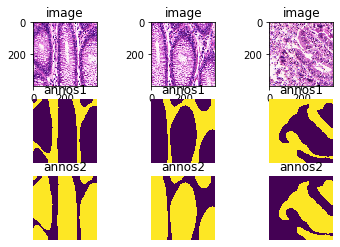

In [10]:
imtest = torch.from_numpy(train_image)

annos = torch.from_numpy(train_annos)


for k in range(3):
    
    imshow = imtest.permute(0,2,3,1)
    plt.subplot(3, 3, k+1)
    plt.imshow(imshow[k,:,:,:])
    plt.title('image')
    plt.subplot(3, 3, k+4)
    plt.imshow(annos[k,:,:,0])
    plt.title('annos1')
    plt.axis('off')
    plt.subplot(3, 3, k+7)
    plt.imshow(annos[k,:,:,1])
    plt.title('annos2')
    plt.axis('off')

In [10]:

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn0=nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1=nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2=nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn3=nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec0=nn.BatchNorm2d(64)
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec1=nn.BatchNorm2d(64)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec2=nn.BatchNorm2d(64)
        self.upsample3 = nn.Upsample(400)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 2, 3, padding=1)
        self.bn_dec3=nn.BatchNorm2d(64)
    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bn0(self.enc_conv0(x))))
        e1 = self.pool1(F.relu(self.bn1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bn2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bn3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.bn_dec0(self.upsample0(b))))
        d1 = F.relu(self.dec_conv1(self.bn_dec1(self.upsample1(d0))))
        d2 = F.relu(self.dec_conv2(self.bn_dec2(self.upsample2(d1))))
        d3 = self.dec_conv3(self.bn_dec3(self.upsample3(d2)) ) # no activation
        d3 = torch.softmax(d3,dim=1)
        return d3
    
    

In [11]:
net=SegNet()
print(net)

SegNet(
  (enc_conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1

In [12]:
import torch.optim as optim

criterion = nn.BCELoss() 

optimizer = optim.Adam(net.parameters(), lr=0.001)

#def bce_loss(y_real, y_pred):
#    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))
print(net.parameters())

<generator object Module.parameters at 0x0000027B947E16C8>


In [13]:
num_epoch = 1 
steps=10

# steps = 3 
for epoch in range(num_epoch):  
    running_loss = 0.0
    avg_loss=0.0
    print('* Epoch %d/%d' % (epoch+1, num_epoch))
    net.train()
    for step in range(steps):
        train_image, train_annos = batch_generator("train",trainset,trainmask,batch_size,2,transform)
        images = torch.from_numpy(train_image)
        annos = torch.from_numpy(train_annos)
        annos = annos.float()
        annos = annos.permute(0,3,1,2)
        optimizer.zero_grad()
        outputs = net(images)
      
    
        loss = criterion(outputs, annos)
        loss.backward()
        optimizer.step()
        running_loss += loss.data 

        if step < 34:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, step + 1, running_loss / batch_size))
        running_loss = 0.0
        avg_loss += loss / steps
    print(' -- loss: %f' % avg_loss)       

    

    Y_hat = net(images).detach().cpu()
    clear_output(wait=True)
    imshow=annos.permute(0,2,3,1)
    outshow=Y_hat.permute(0,2,3,1)
    
    for k in range(3):
        plt.subplot(3, 3, k+1)
        plt.imshow(imshow[k,:,:,0])
        plt.title('Real')
        plt.axis('off')

        plt.subplot(3, 3, k+4)
        plt.imshow(outshow[k,:,:,0].detach().numpy(), cmap='gray')
        plt.title('Output1')
        plt.axis('off')
        
        plt.subplot(3,3,k+7)
        plt.imshow(outshow[k,:,:,1].detach().numpy(), cmap='gray')
        plt.title('Output2')
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, num_epoch, avg_loss))
    plt.show()
print('Finished Training')

* Epoch 1/1


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 491520000 bytes. Buy new RAM!


In [ ]:
net.zero_grad()
for p in net.parameters():
    print('data',p.data)
    print('grad',p.grad)


In [ ]:
path_to_testA = 'C:\\Users\\炸酱面\\Downloads\\project\\testA\\raw'
path_to_annoA = 'C:\\Users\\炸酱面\\Downloads\\project\\testA\\anno'

(testsetA,testsetAraw) = namesort("testA/raw",0)
(testmaskA,testmaskAanno) = namesort("testA/anno",1)
(testsetB,testsetBraw) = namesort("testB/raw",0)
(testmaskB,testmaskBanno) = namesort("testB/anno",1)

for i in range(len(testsetA)):
    testsetA[i]=path_to_testA+os.sep+testsetA[i]

for i in range(len(testmaskA)):
    testmaskA[i]=path_to_annoA+os.sep+testmaskA[i]


In [ ]:
# print(testsetAraw[0].shape)
X=np.array(X)
print(X.shape)
X = torch.from_numpy(X)
X = X.float()
X = X.permute(0,3,1,2)
predicition=net(X)
print(len(predicition))


In [ ]:
from PIL import Image

import numpy as np

from sklearn.metrics import f1_score

import glob

import os





class ColorChange:

    def __init__(self):

        self.colors = {

            'background': [0, 0, 0, 0],

            'black': [0, 0, 0, 255],  # Cell - Gland

#             'green': [0, 255, 0, 255],  # Crop - Brazil

#             'yellow': [255, 255, 0, 255],  # Weed - Brazil

#             'gray': [128, 128, 128, 255], # Weed - Eskild

#             'white': [255, 255, 255, 255], # Crop - Eskild

        }



    def rgba_to_mask(self, img):

        ''' Input (H,W,4), output (H,W) '''

        mask = np.zeros([img.shape[0], img.shape[1]], dtype=np.uint8)

        for i, color_value in enumerate(list(self.colors.values())):

            mask[np.sum(img == color_value, axis=2) == 4] = i

        return mask



project = 'gland_images'

dataset = 'gland'



annotations_path = os.getcwd()+os.sep+project+os.sep+dataset+'/test/annotations'

predictions_path = os.getcwd()+os.sep+project+os.sep+dataset+'/test/predictions'

score_path = os.getcwd()+os.sep+project+os.sep+dataset



annotations_list = sorted(glob.glob(annotations_path+'/*.png'))

predictions_list = sorted(glob.glob(predictions_path+'/*.png'))



f1 = 0



for idx in range(len(predictions_list)):

    anno = Image.open(annotations_list[idx]).convert('RGBA')

    anno = np.uint8(anno)

    anno = ColorChange().rgba_to_mask(anno)

    pred = Image.open(predictions_list[idx]).convert('RGBA')

    pred = np.uint8(pred)

    pred = ColorChange().rgba_to_mask(pred)

    for classes in np.unique(anno):

        if classes == 0:

            continue

    y_pred = (pred==classes)*1

    y_true = (anno==classes)*1

    f1 += f1_score(y_true.reshape(-1), y_pred.reshape(-1), average='macro')



f1 /= len(predictions_list)

f = open(score_path+"/f1_score.txt", "w")

f.write("The f1 score is : {0}".format(f1))

f.close()



print("F1 score for {0} is {1}".format(dataset, f1))